In [1]:
import matplotlib
from matplotlib import pylab
%config InlineBackend.figure_format = 'retina'
matplotlib.rcParams['figure.dpi'] = 80
params = {'legend.fontsize': 'xx-large',
          'figure.figsize': (6, 4),
         'axes.labelsize': 'xx-large',
         'axes.titlesize': 'xx-large',
         'xtick.labelsize': 'x-large',
         'ytick.labelsize': 'x-large',
         'figure.facecolor': 'w'}
pylab.rcParams.update(params)
from matplotlib import pyplot as plt
import matplotlib.gridspec as gridspec

import h5py
import numpy as np
import sys

sys.path.insert(1, '../code')
from featurize_and_fit import Featurizer, Fitter
import plotter
import scalars

%load_ext autoreload
%autoreload 2

In [2]:
save_plots = False
show_intermediate_plots = False
check_cond = False
plot_dir = '../plots/plots_2022-03-03_catalog'
if save_plots:
    !mkdir -p $plot_dir

# r_edges (TNG50-4: L=35 Mpc/h, N_part=270^3, mean interparticle spacing = 35/270 = 0.13 Mpc/h = 130 kpc/h)
# for scalars, only 0 or 2 x orders 
n_rbins = 1
m_order_max = 3
x_order_max = 2
v_order_max = 0
include_eigenvalues = False
include_eigenvectors = False

catalog_feature_names = ['Group_M_Crit200'
                        ]

#y_scalar_feature_name = 'mass_hydro_halo_star'
y_scalar_feature_name='mass_hydro_subhalo_star'

r_units = 'r200'
rms_x = True
log_x = False
log_y = False

#tag = '_unc0.1Mfloor2e8'
#tag = '_logxlogy'
#tag = '_rmsfalse'
#tag = '_velocities'
tag = ''
if include_eigenvalues:
    tag += '_eigvals'

l_arr, p_arr = scalars.get_needed_vec_orders_scalars(x_order_max, v_order_max)

In [3]:
mass_multiplier = 1e10

In [4]:
base_dir = '/scratch/ksf293/equivariant-cosmology/data'
sim_name = 'TNG100-1'
snap_num_str = '099' # z = 0

Must restrict to halo_mass_min=10^10.8 to be consistent with halo structure catalog!
https://www.tng-project.org/data/docs/specifications/#sec5q

In [5]:
featurizer = Featurizer(base_dir, sim_name, snap_num_str)
featurizer.load_halo_dicts(num_star_particles_min=1, halo_mass_min=10**10.8,
                           halo_mass_min_str='1e10.8', halo_mass_difference_factor=3.0,
                           force_reload=False)

Halo file ../data/halo_dicts_TNG100-1_nstarmin1_hmassmin1e10.8_mdifffac3.0.npy exists, loading


In [6]:
featurizer.N_halos

20098

In [7]:
catalog_feature_names = ['M200c', 'c200c', 'a_form']
featurizer.get_catalog_features(catalog_feature_names)

96 halos with NaN values of structure properties detected!


Text(0, 0.5, '$c_\\mathrm{200c}$, halo concentration ')

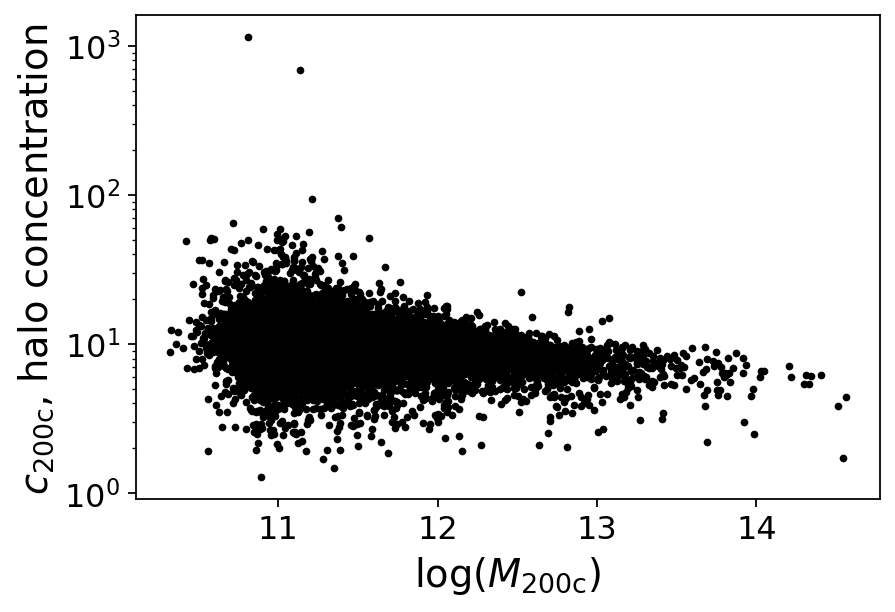

In [8]:
plt.scatter(featurizer.x_catalog_features[:,0], featurizer.x_catalog_features[:,1], s=6, c='k')
plt.yscale('log')
plt.xlabel(r'log($M_\mathrm{200c}$)')
plt.ylabel('$c_\mathrm{200c}$, halo concentration ')

(0.0, 1.0)

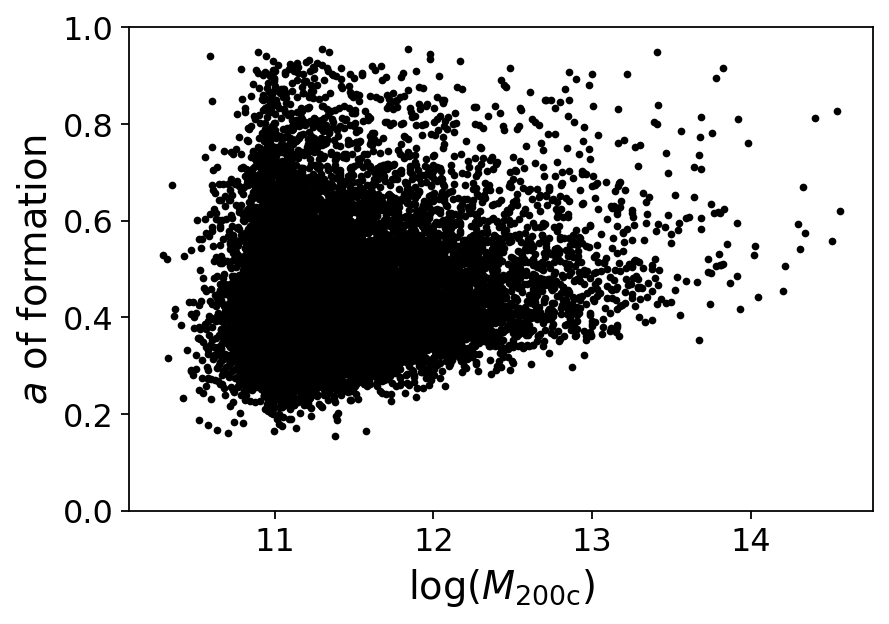

In [9]:
plt.scatter(featurizer.x_catalog_features[:,0], featurizer.x_catalog_features[:,2], s=6, c='k')
plt.xlabel(r'log($M_\mathrm{200c}$)')
plt.ylabel('$a$ of formation')
plt.ylim(0, 1)

## Set up fit

In [12]:
def broken_power_law_feature(M200, N=0.01, M1=1e12/mass_multiplier, beta=1.5, gamma=0.4):
    return M200*2*N/((M200/M1)**(-beta) + (M200/M1)**gamma)

In [13]:
m200_halo = np.array([h['mass_mean200_dark_halo_dm'] for h in featurizer.halo_dicts])
y_val_current = broken_power_law_feature(m200_halo)

In [14]:
y_scalar_feature_name='mass_hydro_subhalo_star'
featurizer.set_y_labels(y_scalar_feature_name=y_scalar_feature_name)

In [15]:
uncertainty_floor = 2e8/mass_multiplier
uncertainties = np.sqrt((0.1*featurizer.y_scalar)**2 + uncertainty_floor**2) # uncertainties are 0.1*M_stellar (M_stellar is our label)

## Check out power law

TODO: figure out: Why is power law so different depending on size/resolution of sim?

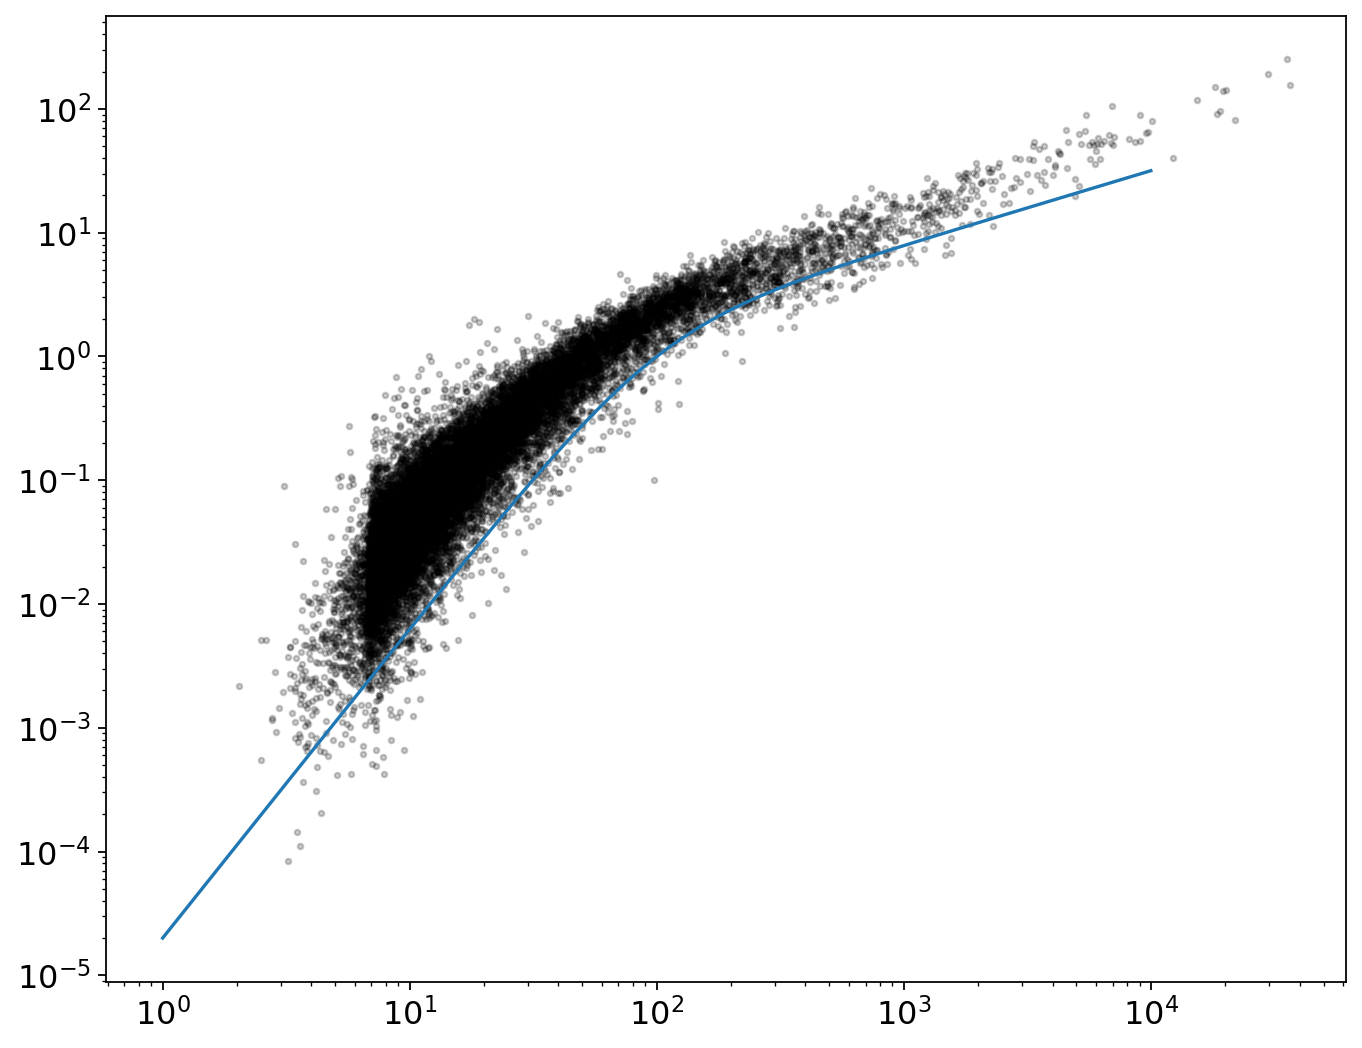

In [17]:
plt.figure(figsize=(10,8))
m_stellar = featurizer.y_scalar
plt.scatter(m200_halo, m_stellar, c='k', alpha=0.2, s=6)

M = np.logspace(10, 14, 100)
M /= mass_multiplier
m = broken_power_law_feature(M)
plt.plot(M, m)

plt.xscale('log')
plt.yscale('log')

## Do fit

In [18]:
# Deleting nan entries for now
x_catalog_features = np.delete(featurizer.x_catalog_features, featurizer.idxs_nan, axis=0)
y_scalar = np.delete(featurizer.y_scalar, featurizer.idxs_nan, axis=0)
y_val_current = np.delete(y_val_current, featurizer.idxs_nan, axis=0)
uncertainties = np.delete(uncertainties, featurizer.idxs_nan, axis=0)

In [19]:
# Fit to those features
fitter = Fitter(x_catalog_features, y_scalar, 
                y_val_current, uncertainties=uncertainties)
fitter.split_train_test()
fitter.scale_and_fit(rms_x=rms_x, log_x=log_x, log_y=log_y, check_cond=check_cond)
fitter.predict_test()

In [20]:
# Extract arrays and plot
y_true = fitter.y_scalar_test*mass_multiplier
y_pred = fitter.y_scalar_pred*mass_multiplier
msfe_test = np.mean(((y_pred - y_true)/y_true)**2)

y_train_pred = fitter.predict(fitter.x_scalar_train, fitter.y_val_current_train)*mass_multiplier
y_train_true = fitter.y_scalar_train*mass_multiplier

chi2_train = fitter.chi2

## Plots

In [21]:
save_tag = '_catalog'
if not save_plots:
    save_tag = None

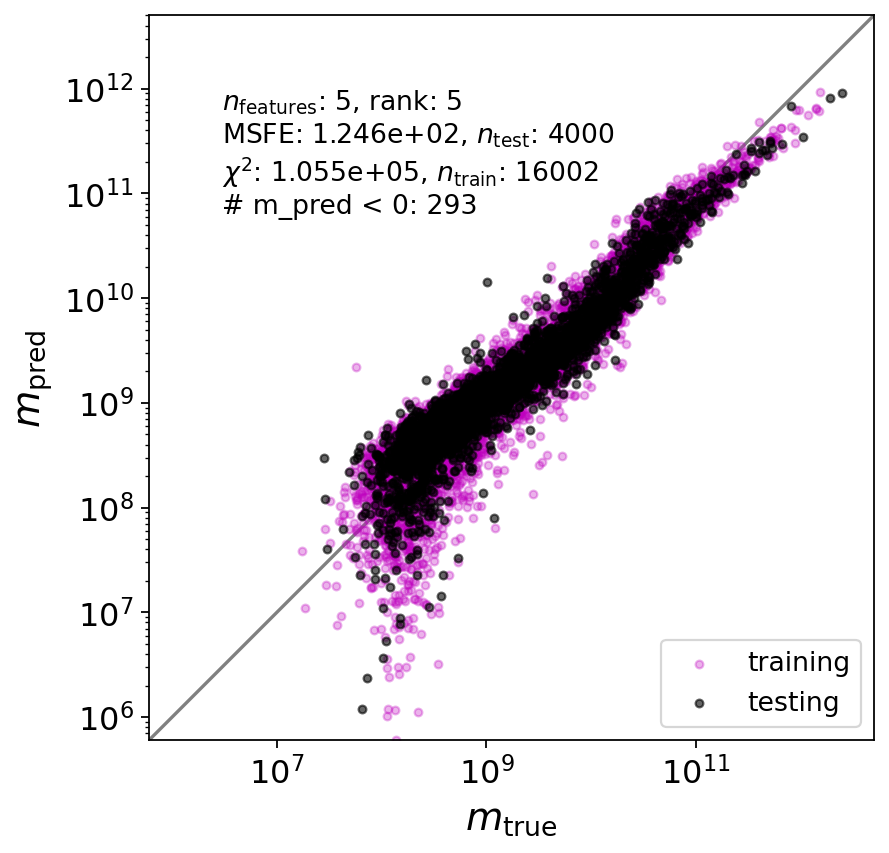

In [22]:
plotter.plot_pred_vs_true(y_true, y_pred, y_train_true, y_train_pred, 
                          fitter, msfe_test, chi2_train, mass_multiplier,
                          plot_dir=plot_dir, save_tag=save_tag)

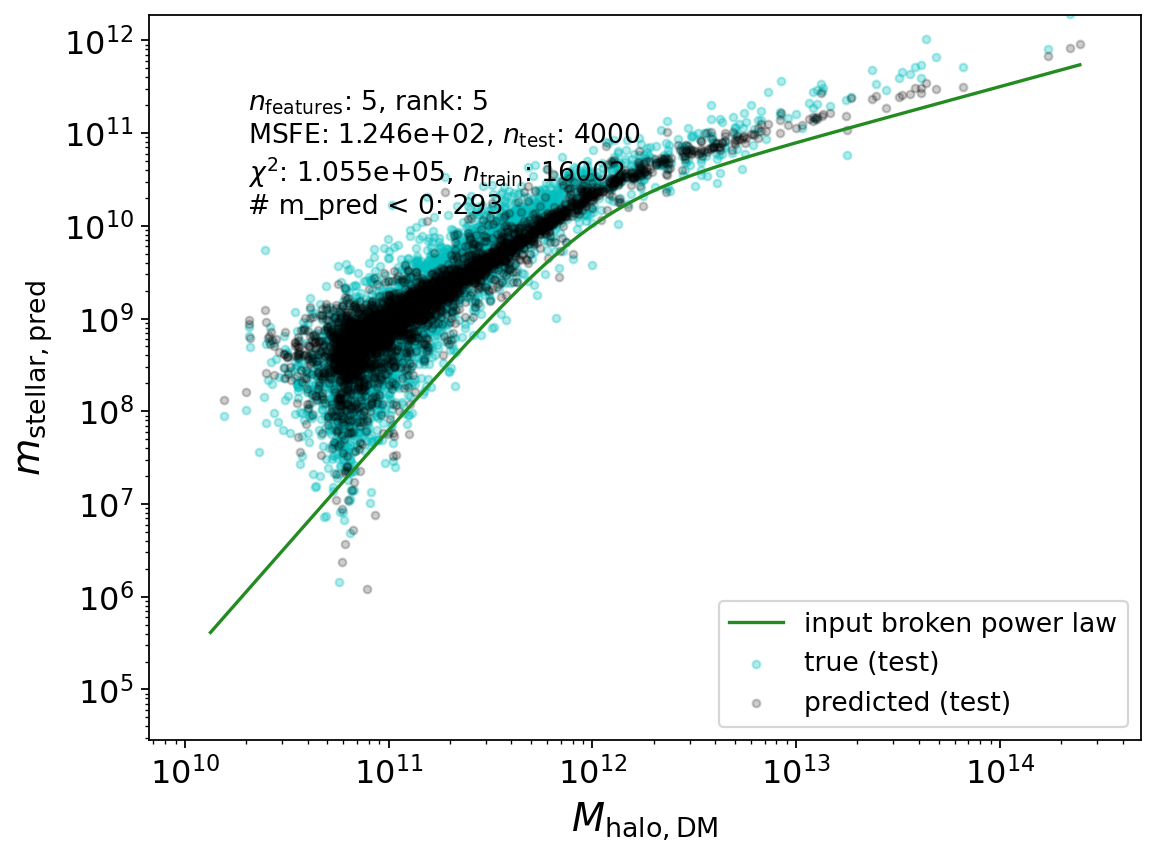

In [23]:
masses_all = np.array([h['mass_crit200_dark_halo_dm'] for h in featurizer.halo_dicts])*mass_multiplier
mass = masses_all[fitter.idx_test]
mass_train = masses_all[fitter.idx_train]
plotter.plot_pred_vs_mass(mass, y_true, y_pred, mass_train, y_train_true, y_train_pred, 
                          fitter, msfe_test, chi2_train, mass_multiplier,
                          plot_dir=plot_dir, save_tag=save_tag, overplot_function=broken_power_law_feature)